<a href="https://colab.research.google.com/github/kklausmeyer/geo_design_tools/blob/master/Copy_of_ee_api_colab_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2019 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Earth Engine Python API Colab Setup

This notebook demonstrates how to setup the Earth Engine Python API in Colab and provides several examples of how to print and visualize Earth Engine processed data.

## Import API and get credentials

The Earth Engine API is installed by default in Google Colaboratory so requires only importing and authenticating. These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

### Import the API

Run the following cell to import the API into your session.

In [1]:
import ee

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=RvqRVrcV3B4O-418FpWLoO2xi4B8yg0uZPJUvkP2ZkE&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g4WrtiUGkO96URj4F1UCet6k3uWGohR_TYYsgNd1id2xuoySdJfe2g

Successfully saved authorization token.


### Test the API

Test the API by printing the elevation of Mount Everest.

In [3]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


## Map visualization

`ee.Image` objects can be displayed to notebook output cells. The following two
examples demonstrate displaying a static image and an interactive map.


### Static image

The `IPython.display` module contains the `Image` function, which can display
the results of a URL representing an image generated from a call to the Earth
Engine `getThumbUrl` function. The following cell will display a thumbnail
of the global elevation model.

In [4]:
# Import the Image function from the IPython.display module. 
from IPython.display import Image

# Display a thumbnail of global elevation.
Image(url = dem.updateMask(dem.gt(0))
  .getThumbURL({'min': 0, 'max': 4000, 'dimensions': 512,
                'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

### Interactive map

The [`folium`](https://python-visualization.github.io/folium/)
library can be used to display `ee.Image` objects on an interactive
[Leaflet](https://leafletjs.com/) map. Folium has no default
method for handling tiles from Earth Engine, so one must be defined
and added to the `folium.Map` module before use.

The following cell provides an example of adding a method for handing Earth Engine
tiles and using it to display an elevation model to a Leaflet map.

In [5]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a folium map object.
my_map = folium.Map(location=[20, 0], zoom_start=3, height=500)

# Add the elevation model to the map object.
my_map.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

## Chart visualization

Some Earth Engine functions produce tabular data that can be plotted by
data visualization packages such as `matplotlib`. The following example
demonstrates the display of tabular data from Earth Engine as a scatter
plot. See [Charting in Colaboratory](https://colab.sandbox.google.com/notebooks/charts.ipynb)
for more information.

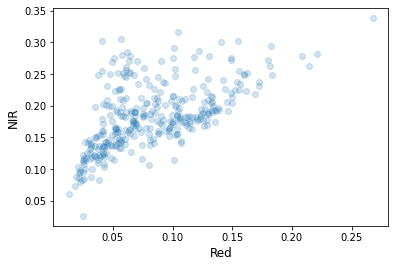

In [6]:
# Import the matplotlib.pyplot module.
import matplotlib.pyplot as plt

# Fetch a Landsat image.
img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

# Select Red and NIR bands, scale them, and sample 500 points.
samp_fc = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()